In [1]:
import onnxruntime

opt_session = onnxruntime.SessionOptions()
opt_session.enable_mem_pattern = False
opt_session.enable_cpu_mem_arena = False
opt_session.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_DISABLE_ALL

In [2]:
model_path = './onnx_models/yolov8n.onnx'
EP_list = ['CUDAExecutionProvider', 'CPUExecutionProvider']

ort_session = onnxruntime.InferenceSession(model_path, providers=EP_list)

c:\Users\hirahara\anaconda3\envs\onnx\lib\site-packages\onnxruntime\capi\onnxruntime_inference_collection.py:65: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'CPUExecutionProvider'
  warnings.warn(


In [3]:
model_inputs = ort_session.get_inputs()
input_names = [model_inputs[i].name for i in range(len(model_inputs))]
input_shape = model_inputs[0].shape
input_shape

[1, 3, 480, 640]

In [4]:
model_output = ort_session.get_outputs()
output_names = [model_output[i].name for i in range(len(model_output))]

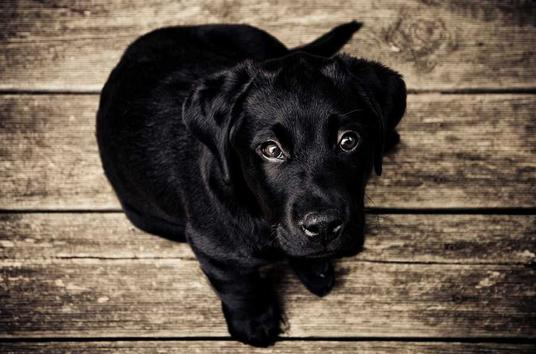

In [5]:
import cv2
import random
import numpy as np
from PIL import Image
from pathlib import Path

img_dir = Path("./sample_data/")

sample_imgPath = random.choice(list(img_dir.glob("*.jpg")))
image = cv2.imread(str(sample_imgPath))

image_height, image_width = image.shape[:2]
Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [6]:
input_height, input_width = input_shape[2:]
image_rgb = image[:,:,::-1]
resized = cv2.resize(image_rgb, (input_width, input_height))

# Scale input pixel value to 0 to 1
input_image = resized / 255.0
input_image = input_image.transpose(2,0,1)
input_tensor = input_image[np.newaxis, :, :, :].astype(np.float32)
input_tensor.shape

(1, 3, 480, 640)

In [7]:
outputs = ort_session.run(output_names, {input_names[0]: input_tensor})[0]

In [8]:
predictions = np.squeeze(outputs).T
conf_thresold = 0.8
# Filter out object confidence scores below threshold
scores = np.max(predictions[:, 4:], axis=1)
predictions = predictions[scores > conf_thresold, :]
scores = scores[scores > conf_thresold]  

In [9]:
# Get the class with the highest confidence
class_ids = np.argmax(predictions[:, 4:], axis=1)

In [10]:
# Get bounding boxes for each object
boxes = predictions[:, :4]

#rescale box
input_shape = np.array([input_width, input_height, input_width, input_height])
boxes = np.divide(boxes, input_shape, dtype=np.float32)
boxes *= np.array([image_width, image_height, image_width, image_height])
boxes = boxes.astype(np.int32)
boxes

array([[251, 184, 317, 327],
       [251, 183, 315, 327],
       [249, 183, 316, 327],
       [252, 182, 318, 329],
       [251, 181, 315, 331],
       [249, 180, 317, 331],
       [252, 179, 318, 334]])